# Predicting Telco Customer Churn

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel("Telco_customer_churn.xlsx")
#Removing unnecessary columns
df = df.drop(['Zip Code','Churn Reason','City','Churn Score','CLTV','CustomerID','Lat Long',
                  'Latitude','Longitude'], axis = 1)
df

,Count,Country,State,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value
0,1,United States,California,Male,No,No,No,2,Yes,No,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
1,1,United States,California,Female,No,No,Yes,2,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
2,1,United States,California,Female,No,No,Yes,8,Yes,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1
3,1,United States,California,Female,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1
4,1,United States,California,Male,No,No,Yes,49,Yes,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,United States,California,Female,No,No,No,72,Yes,No,...,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0
7039,1,United States,California,Male,No,Yes,Yes,24,Yes,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No,0
7040,1,United States,California,Female,No,Yes,Yes,72,Yes,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No,0
7041,1,United States,California,Female,No,Yes,Yes,11,No,No phone service,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0


# Data Pre-processing

In [5]:
df['Total Charges_int'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges_int'].dtype
df['Total Charges_int'].fillna(0,inplace=True)

#convert chosen categorical variable into dummy variable
df1 = pd.get_dummies(df, columns=["Multiple Lines"], prefix=["ML_Category"])
df1 = pd.get_dummies(df1, columns=["Internet Service"], prefix=["IS_Category"])
df1 = pd.get_dummies(df1, columns=["Online Security"], prefix=["OS_Category"])
df1 = pd.get_dummies(df1, columns=["Online Backup"], prefix=["OB_Category"])
df1 = pd.get_dummies(df1, columns=["Device Protection"], prefix=["DP_Category"])
df1 = pd.get_dummies(df1, columns=["Tech Support"], prefix=["TS_Category"])
df1 = pd.get_dummies(df1, columns=["Streaming TV"], prefix=["STV_Category"])
df1 = pd.get_dummies(df1, columns=["Streaming Movies"], prefix=["SM_Category"])
df1['Phone Service'].replace(to_replace='Yes', value=1, inplace=True)
df1['Phone Service'].replace(to_replace='No',  value=0, inplace=True)
df1

,Count,Country,State,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Contract,...,DP_Category_Yes,TS_Category_No,TS_Category_No internet service,TS_Category_Yes,STV_Category_No,STV_Category_No internet service,STV_Category_Yes,SM_Category_No,SM_Category_No internet service,SM_Category_Yes
0,1,United States,California,Male,No,No,No,2,1,Month-to-month,...,0,1,0,0,1,0,0,1,0,0
1,1,United States,California,Female,No,No,Yes,2,1,Month-to-month,...,0,1,0,0,1,0,0,1,0,0
2,1,United States,California,Female,No,No,Yes,8,1,Month-to-month,...,1,1,0,0,0,0,1,0,0,1
3,1,United States,California,Female,No,Yes,Yes,28,1,Month-to-month,...,1,0,0,1,0,0,1,0,0,1
4,1,United States,California,Male,No,No,Yes,49,1,Month-to-month,...,1,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,United States,California,Female,No,No,No,72,1,Two year,...,0,0,1,0,0,1,0,0,1,0
7039,1,United States,California,Male,No,Yes,Yes,24,1,One year,...,1,0,0,1,0,0,1,0,0,1
7040,1,United States,California,Female,No,Yes,Yes,72,1,One year,...,1,1,0,0,0,0,1,0,0,1
7041,1,United States,California,Female,No,Yes,Yes,11,0,Month-to-month,...,0,1,0,0,1,0,0,1,0,0


In [6]:
#Check for missing or null values

missing_values = df.isna()  # or df.isnull()

# Count the number of missing values in each column
missing_count = missing_values.sum()
missing_count

Count                0
Country              0
State                0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
Churn Value          0
Total Charges_int    0
dtype: int64

# Classification using Logistic Regression Model

In [7]:
#Normalize total charges 
df1['Log10_total charges'] = df1['Total Charges_int'].apply(lambda x: 0 if x == 0 else np.log10(x))

In [9]:
#Multivariate Log Regression Model 
X = df1[['Tenure Months',                                                            #Tenure Months
         'Log10_total charges',                                                      #Total Charges
        'ML_Category_No','ML_Category_No phone service','ML_Category_Yes',           #Multiple Lines 
       'IS_Category_DSL','IS_Category_Fiber optic','IS_Category_No',                 #Internet Service
        'Phone Service',                                                             #Phone Service
        'OS_Category_No','OS_Category_No internet service','OS_Category_Yes',        #Online Security 
        'OB_Category_No','OB_Category_No internet service','OB_Category_Yes',        #Online Backup 
        'DP_Category_No','DP_Category_No internet service','DP_Category_Yes',        #Device Protection
        'TS_Category_No','TS_Category_No internet service','TS_Category_Yes',        #Tech Support
        'STV_Category_No','STV_Category_No internet service','STV_Category_Yes',     #Streaming TV
        'SM_Category_No','SM_Category_No internet service','SM_Category_Yes']]       #Streaming Movies                             
y = df1['Churn Value']  # binary outcome variable

#Data balancing
# Initialize the SMOTE resampler
smote = SMOTE(sampling_strategy = 1)

#Modelling
X,y = smote.fit_resample(X,y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter =1000)

#Hyperparamters tuning 
param_grid = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter
    'penalty': ['l1', 'l2'],      # Penalty term (L1 or L2 regularization)
    'solver': ['liblinear', 'saga']  # Solver for optimization problem
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

accuracy_score(y_test,y_pred)
cfm = confusion_matrix(y_test,y_pred)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


# Measuring Accuracy of Improved Prediction Model - Confusion Matrix

<AxesSubplot:>

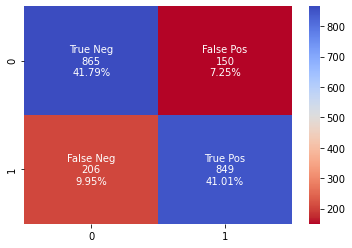

In [10]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm, annot=labels, fmt='', cmap='coolwarm_r')

In [11]:
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall / True Positive Rate: {recall:.2f}")

Accuracy: 0.83
F1 Score: 0.83
Precision: 0.85
Recall / True Positive Rate: 0.80


# Receiver Operating Characteristic (ROC) Curve

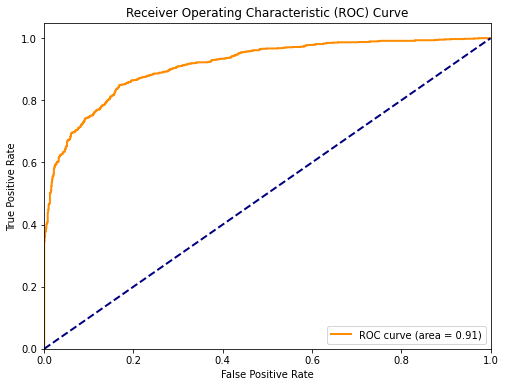

In [13]:
# Get predicted probabilities for the positive class (class 1)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the Curve (AUC) for ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##  Example of using trained logistic regression model to make prediction

In [15]:
# Creating a new example with the same features as training data
new_example = pd.DataFrame({'Tenure Months': [13], 'Log10_total charges': [5.5], 
        'ML_Category_No': [1],'ML_Category_No phone service': [0],'ML_Category_Yes': [0],           
        'IS_Category_DSL': [0],'IS_Category_Fiber optic': [1],'IS_Category_No': [0],                 
        'Phone Service': [1],                                                             
        'OS_Category_No': [1],'OS_Category_No internet service': [0],'OS_Category_Yes': [0],         
        'OB_Category_No': [1],'OB_Category_No internet service': [0],'OB_Category_Yes': [0],        
        'DP_Category_No': [1],'DP_Category_No internet service': [0],'DP_Category_Yes': [0],        
        'TS_Category_No': [0],'TS_Category_No internet service': [0],'TS_Category_Yes': [1],        
        'STV_Category_No': [0],'STV_Category_No internet service': [0],'STV_Category_Yes': [1],     
        'SM_Category_No': [0],'SM_Category_No internet service': [0],'SM_Category_Yes': [1]})

# Use the trained model to make a prediction for the new example
predicted_class = best_model.predict(new_example)

# You can also obtain the predicted probabilities using predict_proba
predicted_probabilities = best_model.predict_proba(new_example)

print("Predicted Class:", predicted_class)
print("Predicted Probabilities:", predicted_probabilities)

Predicted Class: [0]
Predicted Probabilities: [[0.96457279 0.03542721]]
